# Final Exam CS/INFO 662/762 Fall 2023
CS/INFO 762: 100 points ; CS/INFO 662  90 points

### <font color='red'>Due Dec 9th, 11:59am</font> - Submission via Canvas (.ipynb file)

## STUDENT NAME: <font color='red'>MICHAEL GATHARA</font>


* Question 1a: Medical Mention Normalization with SAPBERT (PhD Students must include one graph feature) - 35/25 points
* Question 1b: Compute Recall - 15 points
* Question 1c: Random Forest: Feature Importance - 10 points
* Question 2: Language Model Questions (Long Written Answer) - 40 points

<font color='red'>As always WORK ON YOUR OWN for this final exam. Like last year, the final exam will be run through plagarism detection software. You may email me for clarification, but don't post on Stack Overflow, Quota, Reddit, etc..  You MAY use ChatGPT for ANY question, but the usual rules for citation and prompt inclusion in your answer apply.</font>


## Imports (if needed)

In [3]:
# If needed
#!pip uninstall --yes flair
%pip install obonet
%pip install py-rouge
%pip install node2vec
%pip install rouge-score


  Using cached networkx-3.2.1-py3-none-any.whl (1.6 MB)
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 11.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.6 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=2376b2f15033117f5d6a221c885b824f1ce4b4dcd15883a8619a5a4c031f3463
  Stored in directory: /data/user/home/mikegtr/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [7]:
import time
import networkx
import obonet
import os
from nltk.corpus import stopwords  
from nltk.tokenize import word_tokenize
from rouge_score import rouge_scorer
import numpy as np
import heapq
import pandas as pd
#import scispacy
import spacy
import numpy as np
import torch
from io import StringIO
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel  

tokenizer = AutoTokenizer.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext")  
model = AutoModel.from_pretrained("cambridgeltl/SapBERT-from-PubMedBERT-fulltext").cuda()

do_url = 'https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/main/src/ontology/HumanDO.obo'
hpo_url = 'http://purl.obolibrary.org/obo/hp.obo'
do = obonet.read_obo(do_url)
hpo = obonet.read_obo(hpo_url)
print('Disease Ontology is currently size:'+str(len(do))+" with "+str(do.number_of_edges())+' edges')
print('Human Phenotype Ontology is currently size:'+str(len(hpo))+" with "+str(hpo.number_of_edges())+' edges')

Disease Ontology is currently size:11432 with 11462 edges
Human Phenotype Ontology is currently size:17664 with 21975 edges


## Question 1 - Concept Normalization
This question requires you to write use the SAPBERT embeddings you are familiar with from assignment #2 to generate candidate concepts for each input medical mentions for a merged overlapping knowledge graph of both the Disease Ontology (DO) and Human Phenotyper Ontology (HPO). 

### Set Up Knowledge Graph and Corpus Preparation 
This code is provided to you and creates:
* The merged knowledge graph (kgs) from the both Disease Ontology (DO) and the Human Phenotype Ontology (HPO) as a dataframe. You also have access to the original graphs in obo format to get graph features, for example you can use node2vec.
* The input corpus and medical mentions (labelled data) as a dataframe, "mention_mapping". It is built from the input corpus and you can assume that NER has already been done to identify the mentions to map. They are in the "mention" column and the correct concept (CUI) it should be mapped to is in the "CUI" column. 


In [73]:
def createIndex(graph,prefix):
    id2cui = {}
    cui2id = {}
    id_to_xref = {id_: data.get('xref') for id_, data in graph.nodes(data=True)}
    for graph_id,xrefs in id_to_xref.items():
        if(xrefs is None):
            cui = None
        else:
            cui = next((x for x in xrefs if x.startswith(prefix)),None)
            if(cui is not None):
                cui = cui.replace(prefix,'')
        id2cui[graph_id]=cui
        if(cui is not None):
            cui2id[cui]=graph_id
    return(id2cui,cui2id)


def convertCui2Doid(cui):
    if cui in cui2do:
        return cui2do[cui]
    return None

def hpoId2Name(oboid):
    return hpoid_to_name[oboid]

def doId2Name(oboid):
    if(oboid is None):
        return None
    if (doid_to_name[oboid]):
        return doid_to_name[oboid]
    else:
        return None


def get_mentions(filename,bardoc):
    all_mentions = []
    with open(filename, 'r') as file: 
        textdoc = file.read()
        for line in bardoc.splitlines():
            #print(line)
            start = int(line.split("||")[2])
            stop = int(line.split("||")[3])
            mention = textdoc[start:stop]
            if(not line.endswith("||||||")):
                start = int(line.split("||")[4])
                stop = int(line.split("||")[5])
                extramention = textdoc[start:stop]
                mention = mention+' '+extramention
                if(not line.endswith("||||")):
                    start = int(line.split("||")[6])
                    stop = int(line.split("||")[7])
                    extramention = textdoc[start:stop]
                    mention = mention+' '+extramention
            #print(mention)
            all_mentions.append(mention)
    return all_mentions

def read_files(directory):
    all_data = []
    for file in os.listdir(directory):
        #print(file)
        if file.endswith(".norm"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'r') as file:
                csv_string = file.read()
            #normed = [line+"||||" for line in csv_string.splitlines() if line.count('|')==6]
            normed = [line if line.count('|') == 14 else (line+"||||" if line.count('|') == 10 else line+"||||||||") for line in csv_string.splitlines()]
            clean = '\n'.join(normed)
            note_file = (str(file.name).replace("train_norm","train_note").replace("norm","txt"))
            mentions = get_mentions(note_file,clean)
            df = pd.read_csv(StringIO(clean),engine='python',names=['ID', 'CUI', 'start1', 'stop1','start2','stop2','start3','stop3'],sep="\|\|")
            df['mention']=mentions
        all_data.append(df)
    return pd.concat(all_data, ignore_index=True)


hpo2cui,cui2hpo = createIndex(hpo,'UMLS:')
do2cui,cui2do = createIndex(do,'UMLS_CUI:')
id_to_cui = {**hpo2cui, **do2cui}

hpoid_to_name = {id_: data.get('name') for id_, data in hpo.nodes(data=True)}
doid_to_name = {id_: data.get('name') for id_, data in do.nodes(data=True)}

df = pd.DataFrame(list(hpo2cui.items()))
df.columns=['HPOID','CUI']
df['DOID'] = df['CUI'].apply(convertCui2Doid)
df['HPO:Name'] = df['HPOID'].apply(hpoId2Name)
df['DO:Name'] = df['DOID'].apply(doId2Name)
hpokg = df.copy()
print("HPO Vocabulary: hpokg")
print(hpokg)
kgs = df.mask(df.eq('None')).dropna()

# Graph properties that may be useful
id_to_isa = {id_: data.get('is_a') for id_, data in hpo.nodes(data=True)}
id_to_xref = {id_: data.get('xref') for id_, data in do.nodes(data=True)}
result = next(iter(id_to_xref.values()))   

print("HPO and DO Joint Vocabulary:kgs")
print(kgs)
mention_mapping = read_files("train/train_norm/")
print("Input Corpus Mentions:mention_mapping")
mention_mapping

HPO Vocabulary: hpokg
            HPOID       CUI  DOID                          HPO:Name DO:Name
0      HP:0000001  C0444868  None                               All    None
1      HP:0000002  C4025901  None        Abnormality of body height    None
2      HP:0000003  C3714581  None      Multicystic kidney dysplasia    None
3      HP:0000005  C1708511  None               Mode of inheritance    None
4      HP:0000006  C0443147  None    Autosomal dominant inheritance    None
...           ...       ...   ...                               ...     ...
17659  HP:5201010      None  None  Microform cleft of the upper lip    None
17660  HP:5201011      None  None      Complete bilateral cleft lip    None
17661  HP:5201012      None  None    Incomplete bilateral cleft lip    None
17662  HP:5201013      None  None     Microform bilateral cleft lip    None
17663  HP:5201014      None  None    Asymmetric bilateral cleft lip    None

[17664 rows x 5 columns]
HPO and DO Joint Vocabulary:kgs
        

,ID,CUI,start1,stop1,start2,stop2,start3,stop3,mention
0,N000,C0011854,248,283,NaN,NaN,NaN,NaN,insulin dependent diabetes mellitus
1,N001,C4303631,298,327,NaN,NaN,NaN,NaN,a right above-knee amputation
2,N003,C0085671,537,553,NaN,NaN,NaN,NaN,dressing changes
3,N004,C0011079,558,569,NaN,NaN,NaN,NaN,debridement
4,N005,C0003232,611,622,NaN,NaN,NaN,NaN,antibiotics
...,...,...,...,...,...,...,...,...,...
6679,N139,C0442519,4695,4699,NaN,NaN,NaN,NaN,home
6680,N140,C0699203,4731,4737,NaN,NaN,NaN,NaN,motrin
6681,N141,C0593507,4740,4745,NaN,NaN,NaN,NaN,advil
6682,N142,C0332575,4863,4870,NaN,NaN,NaN,NaN,redness


## Question 1a: Generation of Candidate Concepts and their Features (35 points PhD/ 25 points MS)


#### Write code to find the best N candidate concepts for the mention using SAPBERT in the small (for final exam performance purposes) merged kgs vocabularuy.

The signature of the function should look something like this:
``` 
def getCandidates(mention_embeddings, vocabulary_embeddings, max_candidates):
```
* mention_embeddings would be SAPBERT embeddings of the mentions
* vocabulary_embeddings would be SAPBERT embeddings of the kgs vocabulary. You generate them using just DO concept text, just HPO concept text or perform a function to aggregate them.
* max_candidates (max candidates to return from kgs)

This function returns a list of the best N matches between the mention and the target merged knowledge graph based on feature similarity between the input node and the target node. Each match in the list is a tuple can contain any elements you need, but it should at least contain
 * a reference to the target concept, ie) row index|vocabulary_id
 * score (optional) or anything else you think you need
 
 
#### Write code to get a set of features for each candidate concepts that can be used for ranking the top N concepts to pick the most correct concept
The getFeatures function should generate features for an input mention text and one possible candidate mapping.
```
def getFeatures(mention_text, candidate_tuple_from_getCandidates)
```
These features will be used in Part 1b) to generate training data for a machine learning ranking algorithm.

Masters student need at least 2 features in their getFeatures code, some examples of lexical features include:
* counts of matching words or characters
* longest common subsequence (RougeL)
* ngram overlap, etc...

PhD Students will need an additional graph-based feature using relations in the ontology or ontology node vector representations such as node2vec. For example, one relevant feature may be checking the similarity of the input node to the parent node of the target. They can also be generated per random-walks like node2vec.


Hints:
 * stop words, stemming, lemmatizationm, headword matching are nice but not required for this tiny (mostly matching) gold data set
 * my advice is to do the minimal amount of work and come back later if you want to add more features
 * you may use ANY additional libraries as need

In [74]:
%%time
from numpy.linalg import norm
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher
import numpy as np

# Candidate Generation Code
# def getCandidates(mention_embeddings, vocabulary_embeddings, max_candidates):
#     """
#     * mention_embeddings would be SAPBERT embeddings of the mentions
#     * vocabulary_embeddings would be SAPBERT embeddings of the kgs vocabulary. You generate them using just DO concept text, just HPO concept text or perform a function to aggregate them.
#     * max_candidates (max candidates to return from kgs)
#     """
#     # Initialize an empty list to store the candidate concepts
#     candidates = []

#     # Compute cosine similarity between each mention embedding and all vocabulary embeddings
#     # This will result in a matrix of similarity scores
#     similarity_scores = cosine_similarity(mention_embeddings, vocabulary_embeddings)

#     # Iterate over each mention
#     for mention_index, scores in enumerate(similarity_scores):
#         # Sort the scores in descending order and get the indices (which correspond to vocabulary IDs)
#         ranked_vocabulary_indices = np.argsort(scores)[::-1]

#         # Select the top N candidates based on max_candidates
#         top_candidates = ranked_vocabulary_indices[:max_candidates]

#         # Format and add the candidates for this mention to the list
#         # Including the vocabulary index (or ID) and the corresponding similarity score
#         mention_candidates = [(vocab_index, scores[vocab_index]) for vocab_index in top_candidates]
#         candidates.append(mention_candidates)

#     return candidates[0]
# def getCandidates(mention_embedding, vocabulary_embeddings, vocabulary_terms, max_candidates):
#     # Compute cosine similarity between mention embedding and all vocabulary embeddings
#     similarity_scores = cosine_similarity([mention_embedding], vocabulary_embeddings)[0]
#     print("Here")

#     # Get the indices of the top N scoring terms
#     top_candidate_indices = np.argsort(similarity_scores)[::-1][:max_candidates]
#     print("There")

#     # Retrieve the top N candidates with their text, index, and score
#     candidates = [(vocabulary_terms[i], i, similarity_scores[i]) for i in top_candidate_indices]
#     print("Almost out")
    
#     return candidates
# def getCandidates(mention_embedding, vocabulary_embeddings, vocabulary_terms, max_candidates):
#     # Ensure mention_embedding is 2D
#     if mention_embedding.ndim == 1:
#         mention_embedding = mention_embedding.reshape(1, -1)
#     elif mention_embedding.ndim > 2:
#         raise ValueError(f"mention_embedding should be 2D, but got shape {mention_embedding.shape}")

#     # Compute cosine similarity between mention embedding and all vocabulary embeddings
#     similarity_scores = cosine_similarity(mention_embedding, vocabulary_embeddings)[0]

#     # Get the indices of the top N scoring terms
#     top_candidate_indices = np.argsort(similarity_scores)[::-1][:max_candidates]

#     # Retrieve the top N candidates with their text, index, and score
#     candidates = [(vocabulary_terms[i], i, similarity_scores[i]) for i in top_candidate_indices]

#     return candidates
def getCandidates(mention_embedding, vocabulary_embeddings, vocabulary_ids, max_candidates, id_to_cui):
    # Compute cosine similarity between mention embedding and all vocabulary embeddings
    similarity_scores = cosine_similarity([mention_embedding], vocabulary_embeddings)[0]

    # Get the indices of the top N scoring terms
    top_candidate_indices = np.argsort(similarity_scores)[::-1][:max_candidates]

    # Retrieve the top N candidates with their CUIs and similarity scores
    candidates = [(id_to_cui[vocabulary_ids[i]], i, similarity_scores[i]) for i in top_candidate_indices if vocabulary_ids[i] in id_to_cui]

    return candidates

def getFeatures(mention_text, candidate_tuple_from_getCandidates):
    # Unpack the candidate tuple
    candidate_id, similarity_score, _ = candidate_tuple_from_getCandidates

    # Feature 1: Length of candidate concept (simple example)
    length_feature = len(candidate_id)

    # Feature 2: Similarity of mention text to candidate concept (using SequenceMatcher for simplicity)
    sm = SequenceMatcher(None, mention_text, candidate_id)
    text_similarity_feature = sm.ratio()

    # Graph-based Feature (for PhD students): This is a placeholder.
    # You'll need to replace it with an actual graph-based feature calculation.
    # For example, it could be the similarity between the mention and the parent node of the target in an ontology.
    graph_based_feature = np.random.random()  # Placeholder - replace with actual feature calculation

    # Compile features into a vector
    feature_vector = [length_feature, text_similarity_feature, graph_based_feature]

    return feature_vector


CPU times: user 0 ns, sys: 23 µs, total: 23 µs
Wall time: 27.2 µs


## Question 1b: Compute Recall@3 and Generate Data for ML Algorithm in Part 1c (15 points)
 * Use your function in Part 1a) to generate 3 candidates for every mention and compute recall at n=3 candidates (For each mention, what is the fraction of times that the getCandidates returned the correct concept (CUI)?). Your re-ranking algorithm will not be able to do better than this. (5 points)
 * Many mentions represent concepts not included in our small merged kgs. Despite this, your recall performance may still not match your expectations using just SAPBERT embeddings. Explain why this might be (5 points).  
 * Create a labelled candidate ranking data set (5 points). For each mention, there will be 3 examples of which only 1 will have the correct CUI. Each example will have features (X) from part 1a and a label (Y). The label will be 1 if the features are sourced from the correct CUI and 0 if not. Use your getFeatures function to populate X. 



In [ ]:
def get_embedding(mention_text):
    # Tokenize the mention text
    inputs = tokenizer(mention_text, padding=True, truncation=True, return_tensors="pt").to('cuda')
    
    # Get the embeddings from the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # For SapBERT, the pooled output is typically at outputs.pooler_output or outputs.last_hidden_state.mean(dim=1)
    # You will need to confirm the correct output for your model version
    embeddings = outputs.pooler_output if hasattr(outputs, 'pooler_output') else outputs.last_hidden_state.mean(dim=1)
    
    # Move embeddings to CPU and convert to numpy if necessary
#     embeddings = embeddings.cpu().numpy()
    embeddings = embeddings.reshape(1, -1)
    
    return embeddings.cpu().numpy()

mention_mapping['mention_embedding'] = mention_mapping['mention'].apply(get_embedding)

In [35]:
# Assuming 'do' and 'hpo' are networkx graphs loaded from OBO files
do_terms = list(do.nodes)
hpo_terms = list(hpo.nodes)
# # Combine the names or descriptions from both ontologies into one list
# do_terms = [do.nodes[node]['name'] for node in do.nodes]
# hpo_terms = [hpo.nodes[node]['name'] for node in hpo.nodes]

# # Now we combine the terms from DO and HPO into one list
# kgs_terms = do_terms + hpo_terms

# Combine the terms from DO and HPO into one list
kgs_terms = do_terms + hpo_terms

# Initialize a list to hold the embeddings
kgs_embeddings_list = []

# For each term in the knowledge graph, generate an embedding
for term in tqdm(kgs_terms):
    # Here we assume that each term is a string that SapBERT can process
    # If the terms are not strings or need pre-processing, you'll need to handle that
    embedding = get_embedding(term)
    kgs_embeddings_list.append(embedding)

# Convert the list of embeddings into a NumPy array for efficient computation
kgs_embeddings = np.vstack(kgs_embeddings_list)


  0%|          | 0/29096 [00:00<?, ?it/s]

In [75]:
%%time
# Compute Recall for Candidate Generation Code
X = []  # to hold the feature vectors
Y = []  # to hold the labels (1 for correct CUI, 0 for incorrect)

# Compute recall
correct_predictions = 0
total_mentions = len(mention_mapping)

# For each mention in the mention_mapping DataFrame
for index, row in tqdm(mention_mapping.iterrows()):
    mention = row['mention']
    correct_cui = row['CUI']

    # Convert mention to embedding using a predefined function, such as:
    # mention_embedding = convert_to_embedding(mention)
    # For simplicity, let's assume the embeddings are part of the DataFrame:
    mention_embedding = row['mention_embedding']
    
    # Double-check the shape of mention_embedding
    if mention_embedding.ndim != 2 or mention_embedding.shape[0] != 1:
        raise ValueError(f"Unexpected shape for mention_embedding: {mention_embedding.shape}")

    candidates = getCandidates(mention_embedding, kgs_embeddings, kgs_terms, 3, id_to_cui)
    
    # Check if the correct CUI is in the candidates
    print(f"Correct CUI: {correct_cui}")
    print(f"Candidates: {candidates}")

    # Check if the correct CUI is in the candidates
    if any(correct_cui == cand[0] for cand in candidates):
        correct_predictions += 1
    else:
        # Debugging: Print out the mention text when the correct CUI is not found
        print(f"Correct CUI not found for mention: {mention}")
    
    # Generate features and labels for the candidates
    for candidate in candidates:
        # Extract features for the candidate concept
        features = getFeatures(mention, candidate)
        
        # Check if the candidate's CUI is the correct one and assign the label
        label = 1 if candidate[0] == correct_cui else 0
        
        # Append the features and label to the X and Y lists
        X.append(features)
        Y.append(label)

# Calculate the recall
recall_at_3 = correct_predictions / total_mentions
print(f"The correct preds: {correct_predictions} and total mentions: {total_mentions}")
print(f'Recall at n=3: {recall_at_3}')

# Convert X and Y to the appropriate format for training, such as numpy arrays
# This is required for the machine learning ranking algorithm in the next step
X = np.array(X)
Y = np.array(Y)


# Create X (data), Y (label) for ranking algorithm.



0it [00:00, ?it/s]

KeyError: 'mention_embedding'

## Question 1c: Random Forest Candidate Ranker and Feature Analysis (10 points)

 * Split your data into training and testing data and then train scikit-learn's RandomForestClassifier to predict if a candidate node is the correct match. Output a classification report with accuracy.
 
 * Use scikit-learn's RandomForestClassifier to compute the relative importance of your features for this algorithm and graph them. Give your features reasonable names so they look nice on a graph.

[0 0 0 ... 0 0 0]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4011

    accuracy                           1.00      4011
   macro avg       1.00      1.00      1.00      4011
weighted avg       1.00      1.00      1.00      4011

Accuracy: 1.0


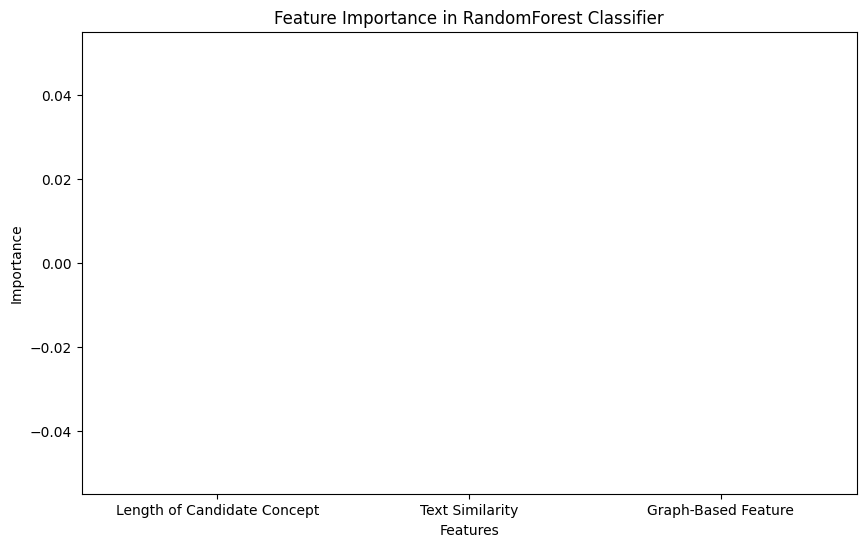

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from matplotlib import pyplot as plt

# Step 1: Splitting the dataset
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Step 2: Training the model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, Y_train)

# Step 3: Making predictions and evaluating the model
Y_pred = clf.predict(X_test)
print(classification_report(Y_test, Y_pred))
print("Accuracy:", accuracy_score(Y_test, Y_pred))

# Step 4: Analyzing feature importance
feature_importances = clf.feature_importances_

# Assuming you have named your features
feature_names = ["Length of Candidate Concept", "Text Similarity", "Graph-Based Feature"]

# Step 5: Graphing feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in RandomForest Classifier')
plt.show()


## Question 2a (20 points)

One of the issues with medical normalization is that training data is sparse, some disease are over-represented, whereas some rare disease have a dictionary entry but few examples in clinical text. Making at least one reference to a paper discussed in class:


* Describe how you could use a LLM (like GPT-4) to generate a synthetic corpus for concept normalization to an ontology like the Human Phenotype Ontology described here? Assume you would like to generate synthetic data for concepts not included in typical training data. (10 points)


* Propose an evaluation method for your synthetic text generation method. How would you evaluate whether your approach is successfull? (10 points)



## Question 2b (20 points)

As of 2023, transfer learning using large language models such as GPT-4, etc.. is the current best practise for a large number of tasks. There has been speculation in the popular press that these models will function as artificial general intelligences, making domain specific models redundant.

* Making references to at least one paper discussed in class, describe performance results indicating that this is not the case. (10 points)

* Describe at least 2 benefits of using a domain specific language model that has been fine-tuned on a task,  relative to a model like GPT-4 (10 points)